In [2]:
import os
import imgaug
from skimage import io, transform
from skimage import img_as_ubyte
from imgaug import augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
import random

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline

In [10]:
# images = np.random.randint(0, 255, (16, 128, 128, 3), dtype=np.uint8)
SAMPLE_PATH = "data/Test/image/001.bmp"
TXT_PATH = "data/Test/AnnotationsByMD/001.txt"

In [11]:
img = img_as_ubyte(io.imread(SAMPLE_PATH, as_gray=True))
img.shape

(2400, 1935)

In [12]:
x,y = img.shape

In [13]:
SCALE = 15

In [14]:
img_dimmed = np.expand_dims(img, axis=0)

In [15]:
img_dimmed

array([[[252, 252, 253, ..., 253, 253,   0],
        [252, 252, 252, ..., 253, 253,   0],
        [252, 252, 252, ..., 253, 253,   0],
        ...,
        [252, 252, 252, ..., 134, 148,   0],
        [254, 254, 254, ..., 140, 136,  10],
        [  0,   0,   0, ...,   3,   1,   0]]], dtype=uint8)

In [16]:
def extract_labels_from_txt(path):
    with open(path, "r") as f:
        # only first 19 are actual coords in dataset label files
        coords_raw = f.readlines()[:19]
        coords_raw = [tuple([int(float(s)) for s in t.split(",")]) for t in coords_raw]
        return coords_raw

In [17]:
coords_raw = extract_labels_from_txt(TXT_PATH)

In [18]:
coords_raw

[(835, 996),
 (1473, 1029),
 (1289, 1279),
 (604, 1228),
 (1375, 1654),
 (1386, 2019),
 (1333, 2200),
 (1263, 2272),
 (1305, 2252),
 (694, 1805),
 (1460, 1870),
 (1450, 1864),
 (1588, 1753),
 (1569, 2013),
 (1514, 1620),
 (1382, 2310),
 (944, 1506),
 (1436, 1569),
 (664, 1340)]

In [19]:
kp_to_list = lambda k_arr: [(p.x, p.y) for p in k_arr]

In [20]:
def list_to_kp(coords_raw):
    kp = []
    for coord in coords_raw:
        kp.append(imgaug.Keypoint(x=coord[0], y=coord[1]))
    keypoints = imgaug.KeypointsOnImage(kp, shape=img.shape)
    return keypoints

In [21]:
keypoints_on_images = [list_to_kp(coords_raw)]

In [22]:
keypoints_on_images

[KeypointsOnImage([Keypoint(x=835.00000000, y=996.00000000), Keypoint(x=1473.00000000, y=1029.00000000), Keypoint(x=1289.00000000, y=1279.00000000), Keypoint(x=604.00000000, y=1228.00000000), Keypoint(x=1375.00000000, y=1654.00000000), Keypoint(x=1386.00000000, y=2019.00000000), Keypoint(x=1333.00000000, y=2200.00000000), Keypoint(x=1263.00000000, y=2272.00000000), Keypoint(x=1305.00000000, y=2252.00000000), Keypoint(x=694.00000000, y=1805.00000000), Keypoint(x=1460.00000000, y=1870.00000000), Keypoint(x=1450.00000000, y=1864.00000000), Keypoint(x=1588.00000000, y=1753.00000000), Keypoint(x=1569.00000000, y=2013.00000000), Keypoint(x=1514.00000000, y=1620.00000000), Keypoint(x=1382.00000000, y=2310.00000000), Keypoint(x=944.00000000, y=1506.00000000), Keypoint(x=1436.00000000, y=1569.00000000), Keypoint(x=664.00000000, y=1340.00000000)], shape=(2400, 1935))]

In [23]:
rs = iaa.Sequential([iaa.Scale({"height":128, "width":128})])
rs_det = rs.to_deterministic()
seq = iaa.Sequential([iaa.Affine(rotate=90)])
seq_det = seq.to_deterministic() # call this for each batch again, NOT only once at the start

In [24]:
images_rs = rs_det.augment_images(img_dimmed)
keypoints_rs = rs_det.augment_keypoints(keypoints_on_images)
images_aug = seq_det.augment_images(images_rs)
keypoints_aug = seq_det.augment_keypoints(keypoints_rs)

In [25]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

In [26]:
plt.rcParams["figure.figsize"] = [16,9]
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 1, 1)

In [27]:
images_rs[0]

array([[250, 251, 247, ..., 253, 253, 253],
       [241, 242,   0, ..., 246, 250, 253],
       [247, 253, 105, ..., 215, 220, 222],
       ...,
       [253, 253, 232, ..., 111, 112, 118],
       [253, 252, 233, ..., 112, 125, 127],
       [253, 253, 235, ..., 116, 122, 129]], dtype=uint8)

In [28]:
ax1.imshow(images_rs[0], cmap="gray")
ax2.imshow(images_aug[0], cmap="gray")

In [29]:
k_orig = kp_to_list(keypoints_rs[0].keypoints)
k_aug = kp_to_list(keypoints_aug[0].keypoints)

In [30]:
ax1.scatter(*zip(*k_orig))
ax2.scatter(*zip(*k_aug))

In [31]:
plt.show()

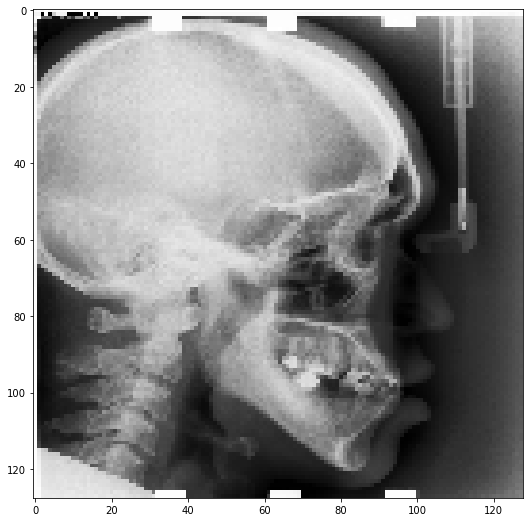

In [32]:
plt.imshow(images_rs[0],cmap='gray')

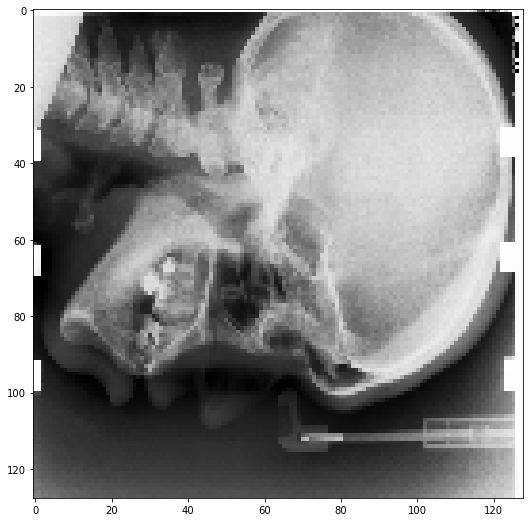

In [33]:
plt.imshow(images_aug[0],cmap='gray')

## Let's see how we can generate rotated images and save them with their corresponding annotations

In [50]:
BASE_PATH = "data/RawImage"
BASE_LABELS = "data/AnnotationsByMD/400_senior"

In [51]:
TEST_BASE_PATH = "data/Test/image"
TEST_BASE_LABELS = "data/Test/AnnotationsByMD"

In [36]:
def img_path_walker(base_path):
    # walk through subdirs to get all image paths
    img_paths = []
    for root, _, files in os.walk(base_path):
        for name in files:
            if name.endswith(".bmp"):
                img_paths.append(os.path.abspath(os.path.join(root, name)))
    return img_paths

In [37]:
def label_walker(base_labels):
    img_labels = {}
    for label_file in os.listdir(base_labels):
        linked_img = label_file[:-3] + "bmp"
        img_labels[linked_img] = extract_labels_from_txt(base_labels + "/" + label_file)
    return img_labels

In [45]:
img_paths = img_path_walker(TEST_BASE_PATH)
img_labels = label_walker(TEST_BASE_LABELS)

In [46]:
len(img_labels)

1

In [47]:
len(img_paths)

1

In [48]:
img_labels

{'001.bmp': [(835, 996),
  (1473, 1029),
  (1289, 1279),
  (604, 1228),
  (1375, 1654),
  (1386, 2019),
  (1333, 2200),
  (1263, 2272),
  (1305, 2252),
  (694, 1805),
  (1460, 1870),
  (1450, 1864),
  (1588, 1753),
  (1569, 2013),
  (1514, 1620),
  (1382, 2310),
  (944, 1506),
  (1436, 1569),
  (664, 1340)]}

In [49]:
img_paths

['D:\\CNN-Cephalometric-Analysis\\data\\Test\\image\\001.bmp']

In [406]:

# shrink = iaa.Sequential(iaa.AdditiveGaussianNoise(scale=(30, 90)))
# augment_functions = [iaa.Fliplr(1.0)]


# augment_functions += [iaa.Affine(rotate=rot_angle) for rot_angle in [180]]

# print(augment_functions)

In [407]:
# shrink = iaa.Sequential([iaa.Scale({"height":256, "width":256})])
# shrink  = iaa.AdditiveGaussianNoise(scale=(30, 90))

# shrink = iaa.Sequential(iaa.AdditiveGaussianNoise(scale=(30, 90)))
# augment_functions = [iaa.Fliplr(1.0)]


# augment_functions += [iaa.Affine(rotate=rot_angle) for rot_angle in [90,180]]
# augment_functions += [iaa.Affine(rotate=90)]
# print(augment_functions)

In [408]:
# shrink = iaa.Scale({"height":224, "width":224})
augment_functions = [iaa.Fliplr(1.0), iaa.Flipud(1.0)]
augment_functions += [iaa.Affine(rotate=rot_angle) for rot_angle in [180]]

In [409]:
def aug_and_save(img, img_name, label, aug_list, base_path):
    kp = [list_to_kp(label)]

#     img = shrink.augment_image(img)
#     kp = shrink.augment_keypoints(kp)
    
    print("**************************")
    img_save_name = base_path + "/" + img_name + "_aug{}".format(0)
    io.imsave(img_save_name + ".bmp", img)
    with open(img_save_name + ".txt", "w") as lf:
            stringified = [str(tup) for tup in kp_to_list(kp[0].keypoints)]
            print("\n".join(stringified))
            stringified = [s.replace("(", "").replace(")","") for s in stringified]
            
            lf.write("\n".join(stringified))
    for i, aug in enumerate(aug_list):
        img_aug = aug.augment_image(img)
        kp_aug = aug.augment_keypoints(kp)
        # save img:
        img_save_name = base_path + "/" + img_name + "_aug{}".format(i+1)
        io.imsave(img_save_name + ".bmp", img_aug)
        # save labelfile:
        with open(img_save_name + ".txt", "w") as lf:
            stringified = [str(tup) for tup in kp_to_list(kp_aug[0].keypoints)]
            stringified = [s.replace("(", "").replace(")","") for s in stringified]
            lf.write("\n".join(stringified))

In [410]:
for i, path in enumerate(img_paths):
    # import as ubyte if want reduced range for small pics
    # loop_img = img_as_ubyte(io.imread(path, as_grey=True))
    # import normally for resnet-18 attempt:
    loop_img = io.imread(path)
    print(loop_img.shape)
    
    loop_labels = img_labels[path.split("/")[-1]]
    #print_image(loop_img, loop_labels)
#     aug_and_save(loop_img, path.split("/")[-1][:-4], loop_labels, augment_functions, "data/images/256/final")
    aug_and_save(loop_img, path.split("/")[-1][:-4], loop_labels, augment_functions, "data/testResults")


(2400, 1935, 3)
**************************
(899, 983)
(1444, 900)
(1368, 1177)
(674, 1239)
(1470, 1511)
(1462, 1812)
(1468, 1976)
(1424, 2052)
(1455, 2023)
(766, 1740)
(1514, 1685)
(1530, 1683)
(1654, 1588)
(1640, 1798)
(1523, 1466)
(1575, 2042)
(1033, 1411)
(1469, 1384)
(774, 1292)
(2400, 1935, 3)
**************************
(792, 951)
(1333, 876)
(1280, 1102)
(562, 1148)
(1379, 1371)
(1360, 1651)
(1348, 1748)
(1291, 1812)
(1333, 1791)
(732, 1564)
(1410, 1511)
(1442, 1517)
(1554, 1448)
(1521, 1620)
(1492, 1327)
(1448, 1804)
(968, 1315)
(1381, 1295)
(652, 1217)
(2400, 1935, 3)
**************************
(896, 1062)
(1483, 1025)
(1372, 1237)
(641, 1213)
(1504, 1613)
(1571, 1984)
(1596, 2130)
(1540, 2217)
(1580, 2179)
(827, 1801)
(1560, 1814)
(1511, 1805)
(1657, 1711)
(1726, 1881)
(1578, 1608)
(1689, 2205)
(999, 1528)
(1515, 1530)
(706, 1354)
(2400, 1935, 3)
**************************
(805, 920)
(1362, 849)
(1280, 1074)
(618, 1153)
(1415, 1354)
(1359, 1687)
(1363, 1831)
(1320, 1889)
(1350

(2400, 1935, 3)
**************************
(761, 974)
(1405, 871)
(1299, 1141)
(589, 1167)
(1395, 1452)
(1288, 1813)
(1281, 1919)
(1229, 1972)
(1272, 1949)
(687, 1728)
(1340, 1608)
(1441, 1620)
(1543, 1542)
(1469, 1767)
(1513, 1426)
(1362, 1997)
(894, 1380)
(1452, 1402)
(605, 1283)
(2400, 1935, 3)
**************************
(739, 1103)
(1261, 990)
(1212, 1222)
(593, 1207)
(1331, 1525)
(1287, 1822)
(1302, 1953)
(1254, 2006)
(1293, 1989)
(689, 1680)
(1337, 1684)
(1384, 1694)
(1484, 1593)
(1445, 1775)
(1425, 1476)
(1379, 1979)
(916, 1473)
(1333, 1443)
(635, 1347)
(2400, 1935, 3)
**************************
(882, 1082)
(1491, 961)
(1372, 1230)
(620, 1281)
(1517, 1558)
(1367, 1950)
(1345, 2087)
(1312, 2115)
(1331, 2108)
(788, 1852)
(1455, 1719)
(1588, 1771)
(1702, 1656)
(1616, 1874)
(1665, 1494)
(1462, 2129)
(1048, 1478)
(1568, 1471)
(749, 1374)
(2400, 1935, 3)
**************************
(849, 1059)
(1468, 1031)
(1329, 1222)
(627, 1245)
(1457, 1519)
(1449, 1821)
(1445, 1940)
(1393, 2002)
(14

(2400, 1935, 3)
**************************
(806, 1000)
(1396, 894)
(1280, 1172)
(586, 1153)
(1420, 1492)
(1498, 1856)
(1536, 1981)
(1504, 2082)
(1528, 2034)
(773, 1722)
(1484, 1697)
(1473, 1686)
(1605, 1611)
(1637, 1741)
(1566, 1467)
(1643, 2071)
(1002, 1418)
(1454, 1394)
(644, 1308)
(2400, 1935, 3)
**************************
(839, 1089)
(1398, 1053)
(1289, 1284)
(615, 1211)
(1370, 1610)
(1272, 1903)
(1177, 2056)
(1108, 2104)
(1153, 2087)
(642, 1712)
(1378, 1776)
(1400, 1808)
(1547, 1724)
(1443, 1963)
(1477, 1594)
(1227, 2158)
(954, 1474)
(1394, 1551)
(641, 1357)
(2400, 1935, 3)
**************************
(886, 1085)
(1464, 1070)
(1341, 1318)
(619, 1260)
(1408, 1670)
(1282, 1940)
(1262, 2081)
(1188, 2151)
(1242, 2137)
(594, 1860)
(1374, 1851)
(1421, 1877)
(1548, 1823)
(1472, 1971)
(1535, 1686)
(1346, 2207)
(963, 1499)
(1450, 1596)
(644, 1376)
(2400, 1935, 3)
**************************
(1028, 1077)
(1585, 964)
(1487, 1220)
(803, 1258)
(1585, 1542)
(1612, 1836)
(1627, 2022)
(1589, 2074)


(2400, 1935, 3)
**************************
(813, 1034)
(1486, 979)
(1341, 1197)
(563, 1227)
(1491, 1529)
(1378, 1802)
(1375, 1950)
(1300, 2033)
(1353, 2013)
(631, 1831)
(1444, 1667)
(1484, 1710)
(1610, 1678)
(1528, 1808)
(1595, 1524)
(1470, 2055)
(959, 1450)
(1499, 1463)
(600, 1369)
(2400, 1935, 3)
**************************
(837, 1091)
(1492, 1018)
(1331, 1276)
(593, 1279)
(1534, 1651)
(1387, 1934)
(1364, 2126)
(1283, 2182)
(1327, 2171)
(714, 1854)
(1478, 1779)
(1545, 1836)
(1685, 1728)
(1606, 1952)
(1653, 1600)
(1429, 2196)
(1021, 1521)
(1459, 1506)
(666, 1390)
(2400, 1935, 3)
**************************
(808, 1062)
(1359, 1081)
(1258, 1255)
(568, 1259)
(1341, 1560)
(1239, 1823)
(1225, 1990)
(1167, 2029)
(1207, 2018)
(611, 1667)
(1318, 1706)
(1346, 1760)
(1483, 1678)
(1398, 1854)
(1402, 1576)
(1317, 2018)
(939, 1458)
(1379, 1510)
(619, 1312)
(2400, 1935, 3)
**************************
(886, 1041)
(1483, 1011)
(1343, 1247)
(639, 1256)
(1462, 1577)
(1385, 1857)
(1344, 1972)
(1275, 2040)


(2400, 1935, 3)
**************************
(862, 1098)
(1413, 1041)
(1329, 1281)
(597, 1284)
(1410, 1645)
(1471, 1985)
(1440, 2182)
(1372, 2215)
(1410, 2213)
(722, 1803)
(1483, 1816)
(1454, 1821)
(1577, 1712)
(1612, 1884)
(1547, 1590)
(1519, 2176)
(999, 1518)
(1441, 1530)
(683, 1413)
(2400, 1935, 3)
**************************
(825, 951)
(1432, 857)
(1326, 1097)
(592, 1183)
(1512, 1467)
(1421, 1803)
(1343, 2025)
(1283, 2057)
(1326, 2052)
(736, 1716)
(1526, 1671)
(1556, 1679)
(1663, 1615)
(1630, 1812)
(1597, 1413)
(1501, 2042)
(1022, 1379)
(1469, 1339)
(701, 1316)
(2400, 1935, 3)
**************************
(816, 1077)
(1385, 967)
(1286, 1229)
(620, 1239)
(1469, 1547)
(1344, 1886)
(1284, 2067)
(1225, 2131)
(1273, 2112)
(754, 1783)
(1497, 1731)
(1529, 1758)
(1655, 1646)
(1568, 1917)
(1584, 1517)
(1381, 2142)
(999, 1481)
(1480, 1470)
(611, 1404)
(2400, 1935, 3)
**************************
(822, 1069)
(1384, 1054)
(1268, 1225)
(612, 1276)
(1458, 1575)
(1386, 1848)
(1326, 2018)
(1264, 2062)
(1

(2400, 1935, 3)
**************************
(765, 1026)
(1320, 1012)
(1236, 1226)
(563, 1216)
(1371, 1553)
(1340, 1870)
(1294, 2048)
(1209, 2092)
(1259, 2090)
(684, 1689)
(1410, 1716)
(1455, 1731)
(1534, 1639)
(1500, 1844)
(1439, 1497)
(1414, 2094)
(936, 1415)
(1361, 1447)
(646, 1313)
(2400, 1935, 3)
**************************
(852, 1133)
(1384, 1145)
(1301, 1360)
(597, 1268)
(1385, 1704)
(1441, 2079)
(1466, 2197)
(1414, 2299)
(1456, 2251)
(741, 1837)
(1442, 1904)
(1413, 1909)
(1597, 1856)
(1597, 1972)
(1544, 1709)
(1579, 2297)
(993, 1575)
(1399, 1625)
(646, 1371)
(2400, 1935, 3)
**************************
(781, 955)
(1399, 865)
(1266, 1118)
(573, 1161)
(1416, 1437)
(1437, 1732)
(1473, 1923)
(1434, 1986)
(1466, 1966)
(774, 1670)
(1443, 1589)
(1457, 1588)
(1602, 1534)
(1608, 1678)
(1537, 1403)
(1594, 1944)
(983, 1365)
(1404, 1369)
(676, 1291)
(2400, 1935, 3)
**************************
(804, 916)
(1362, 852)
(1232, 1089)
(603, 1148)
(1415, 1392)
(1359, 1681)
(1364, 1836)
(1311, 1891)
(134

(2400, 1935, 3)
**************************
(811, 1149)
(1397, 1074)
(1299, 1261)
(587, 1263)
(1431, 1608)
(1242, 1945)
(1225, 2006)
(1165, 2059)
(1207, 2041)
(700, 1734)
(1416, 1777)
(1505, 1830)
(1560, 1639)
(1464, 1935)
(1518, 1566)
(1352, 2005)
(982, 1521)
(1436, 1540)
(690, 1426)
(2400, 1935, 3)
**************************
(798, 1090)
(1370, 1008)
(1252, 1269)
(587, 1279)
(1329, 1572)
(1331, 1945)
(1371, 2060)
(1299, 2135)
(1349, 2113)
(680, 1835)
(1342, 1754)
(1365, 1768)
(1517, 1641)
(1481, 1884)
(1466, 1562)
(1466, 2076)
(948, 1489)
(1356, 1478)
(644, 1418)
(2400, 1935, 3)
**************************
(762, 1037)
(1234, 911)
(1161, 1083)
(595, 1223)
(1296, 1344)
(1269, 1679)
(1262, 1753)
(1209, 1809)
(1241, 1793)
(757, 1618)
(1330, 1513)
(1367, 1499)
(1450, 1376)
(1431, 1602)
(1395, 1305)
(1362, 1721)
(957, 1336)
(1276, 1277)
(671, 1277)
(2400, 1935, 3)
**************************
(754, 1038)
(1399, 943)
(1290, 1165)
(559, 1227)
(1372, 1517)
(1241, 1917)
(1238, 2039)
(1181, 2106)
(1

(2400, 1935, 3)
**************************
(908, 1073)
(1478, 1066)
(1368, 1290)
(717, 1252)
(1414, 1635)
(1411, 2063)
(1420, 2163)
(1376, 2233)
(1403, 2209)
(861, 1875)
(1472, 1839)
(1468, 1850)
(1583, 1731)
(1573, 1987)
(1547, 1630)
(1496, 2159)
(1060, 1495)
(1456, 1577)
(765, 1353)
(2400, 1935, 3)
**************************
(1105, 1047)
(1719, 1023)
(1605, 1261)
(919, 1147)
(1647, 1559)
(1490, 1898)
(1456, 2010)
(1371, 2043)
(1429, 2034)
(971, 1632)
(1612, 1741)
(1622, 1759)
(1796, 1647)
(1673, 1903)
(1747, 1534)
(1571, 1979)
(1269, 1441)
(1674, 1495)
(984, 1273)
(2400, 1935, 3)
**************************
(808, 1028)
(1393, 981)
(1347, 1202)
(633, 1205)
(1435, 1477)
(1453, 1890)
(1478, 2025)
(1420, 2081)
(1461, 2061)
(750, 1829)
(1502, 1706)
(1512, 1707)
(1633, 1563)
(1617, 1810)
(1525, 1488)
(1566, 1981)
(994, 1446)
(1466, 1418)
(688, 1330)
(2400, 1935, 3)
**************************
(779, 1047)
(1382, 938)
(1300, 1175)
(586, 1242)
(1389, 1498)
(1296, 1912)
(1291, 2011)
(1242, 2070)

(2400, 1935, 3)
**************************
(851, 1117)
(1415, 1030)
(1326, 1294)
(620, 1275)
(1399, 1565)
(1372, 1893)
(1397, 1987)
(1349, 2045)
(1378, 2023)
(755, 1784)
(1420, 1753)
(1449, 1768)
(1559, 1674)
(1538, 1865)
(1528, 1570)
(1511, 2001)
(1000, 1523)
(1437, 1525)
(680, 1374)
(2400, 1935, 3)
**************************
(826, 1124)
(1358, 1002)
(1284, 1262)
(615, 1258)
(1374, 1464)
(1340, 1814)
(1345, 1885)
(1299, 1949)
(1331, 1931)
(784, 1696)
(1369, 1644)
(1408, 1641)
(1525, 1542)
(1489, 1738)
(1485, 1461)
(1442, 1871)
(987, 1431)
(1415, 1419)
(692, 1370)
(2400, 1935, 3)
**************************
(775, 987)
(1344, 974)
(1234, 1181)
(532, 1163)
(1272, 1524)
(1248, 1960)
(1262, 2073)
(1220, 2143)
(1252, 2123)
(657, 1784)
(1349, 1744)
(1333, 1742)
(1480, 1651)
(1458, 1895)
(1415, 1536)
(1391, 1994)
(895, 1427)
(1295, 1457)
(608, 1299)
(2400, 1935, 3)
**************************
(712, 1067)
(1271, 980)
(1196, 1207)
(516, 1232)
(1310, 1550)
(1255, 1948)
(1264, 2020)
(1213, 2089)
(1

(2400, 1935, 3)
**************************
(747, 941)
(1319, 984)
(1198, 1195)
(534, 1143)
(1295, 1500)
(1224, 1824)
(1215, 1966)
(1158, 2027)
(1193, 2012)
(621, 1709)
(1322, 1663)
(1366, 1696)
(1508, 1598)
(1433, 1821)
(1402, 1476)
(1326, 2030)
(875, 1366)
(1311, 1424)
(576, 1251)
(2400, 1935, 3)
**************************
(843, 1069)
(1460, 1011)
(1332, 1285)
(614, 1260)
(1458, 1567)
(1525, 1923)
(1503, 2084)
(1435, 2142)
(1480, 2126)
(829, 1775)
(1547, 1759)
(1541, 1757)
(1630, 1679)
(1692, 1867)
(1571, 1549)
(1592, 2138)
(1015, 1500)
(1493, 1490)
(704, 1315)
(2400, 1935, 3)
**************************
(787, 1040)
(1317, 818)
(1244, 1103)
(635, 1226)
(1440, 1375)
(1383, 1671)
(1367, 1825)
(1318, 1886)
(1354, 1867)
(795, 1680)
(1455, 1536)
(1495, 1554)
(1600, 1427)
(1573, 1647)
(1467, 1316)
(1437, 1890)
(1002, 1327)
(1426, 1260)
(702, 1298)
(2400, 1935, 3)
**************************
(749, 1023)
(1303, 982)
(1213, 1211)
(563, 1154)
(1287, 1529)
(1338, 1850)
(1334, 2012)
(1271, 2071)
(1

(2400, 1935, 3)
**************************
(819, 1082)
(1354, 1079)
(1226, 1288)
(584, 1198)
(1294, 1527)
(1238, 1797)
(1191, 1924)
(1161, 1947)
(1184, 1945)
(713, 1631)
(1303, 1681)
(1326, 1699)
(1492, 1596)
(1400, 1794)
(1422, 1522)
(1302, 2060)
(921, 1403)
(1333, 1481)
(646, 1285)
(2400, 1935, 3)
**************************
(864, 1016)
(1514, 971)
(1334, 1224)
(629, 1220)
(1483, 1548)
(1412, 1886)
(1397, 2064)
(1336, 2122)
(1375, 2107)
(768, 1802)
(1508, 1725)
(1543, 1732)
(1666, 1654)
(1637, 1853)
(1594, 1524)
(1487, 2113)
(1042, 1446)
(1479, 1457)
(685, 1346)
(2400, 1935, 3)
**************************
(828, 1073)
(1451, 1087)
(1305, 1385)
(591, 1204)
(1345, 1694)
(1286, 1960)
(1179, 2162)
(1106, 2199)
(1146, 2194)
(602, 1935)
(1347, 1857)
(1380, 1907)
(1522, 1825)
(1451, 1998)
(1482, 1683)
(1231, 2230)
(907, 1542)
(1363, 1610)
(618, 1370)
(2400, 1935, 3)
**************************
(835, 996)
(1473, 1029)
(1289, 1279)
(604, 1228)
(1375, 1654)
(1386, 2019)
(1333, 2200)
(1263, 2272)
(

(2400, 1935, 3)
**************************
(790, 1073)
(1419, 1000)
(1291, 1274)
(603, 1263)
(1407, 1577)
(1351, 1879)
(1325, 2052)
(1265, 2099)
(1302, 2085)
(720, 1836)
(1424, 1711)
(1507, 1773)
(1616, 1719)
(1554, 1888)
(1559, 1564)
(1415, 2112)
(935, 1500)
(1427, 1490)
(628, 1390)
(2400, 1935, 3)
**************************
(764, 970)
(1388, 827)
(1221, 1125)
(584, 1151)
(1461, 1486)
(1429, 1772)
(1411, 1987)
(1342, 2054)
(1387, 2041)
(764, 1736)
(1456, 1618)
(1505, 1634)
(1635, 1546)
(1605, 1755)
(1572, 1404)
(1465, 2060)
(980, 1378)
(1461, 1348)
(654, 1288)
(2400, 1935, 3)
**************************
(766, 969)
(1349, 872)
(1215, 1173)
(584, 1193)
(1372, 1488)
(1367, 1833)
(1357, 2002)
(1298, 2060)
(1335, 2035)
(802, 1749)
(1437, 1689)
(1458, 1683)
(1555, 1593)
(1550, 1805)
(1465, 1445)
(1417, 2074)
(949, 1349)
(1382, 1381)
(666, 1271)
(2400, 1935, 3)
**************************
(802, 946)
(1363, 940)
(1223, 1200)
(621, 1211)
(1267, 1525)
(1296, 1858)
(1289, 2006)
(1257, 2054)
(1281,

(2400, 1935, 3)
**************************
(808, 1025)
(1393, 1050)
(1233, 1299)
(581, 1200)
(1318, 1591)
(1396, 1949)
(1390, 2144)
(1343, 2188)
(1374, 2173)
(737, 1810)
(1438, 1790)
(1371, 1817)
(1491, 1741)
(1538, 1870)
(1401, 1620)
(1470, 2169)
(922, 1449)
(1344, 1544)
(647, 1259)
(2400, 1935, 3)
**************************
(827, 1070)
(1411, 967)
(1273, 1219)
(606, 1283)
(1557, 1582)
(1486, 1842)
(1454, 2008)
(1397, 2067)
(1437, 2047)
(793, 1862)
(1569, 1713)
(1594, 1725)
(1713, 1634)
(1675, 1830)
(1642, 1493)
(1526, 2083)
(1034, 1453)
(1526, 1457)
(687, 1413)
(2400, 1935, 3)
**************************
(838, 1046)
(1352, 952)
(1268, 1201)
(587, 1246)
(1366, 1427)
(1411, 1749)
(1400, 1859)
(1351, 1903)
(1386, 1886)
(786, 1708)
(1452, 1595)
(1446, 1590)
(1568, 1542)
(1554, 1735)
(1521, 1426)
(1474, 1942)
(982, 1386)
(1388, 1398)
(647, 1302)
(2400, 1935, 3)
**************************
(822, 1056)
(1345, 1007)
(1247, 1267)
(597, 1262)
(1313, 1601)
(1290, 1958)
(1270, 2146)
(1215, 2189)
(

(2400, 1935, 3)
**************************
(901, 1048)
(1535, 1009)
(1365, 1269)
(653, 1211)
(1517, 1573)
(1486, 1948)
(1480, 2077)
(1407, 2153)
(1456, 2131)
(835, 1842)
(1546, 1811)
(1577, 1760)
(1701, 1704)
(1668, 1853)
(1661, 1591)
(1569, 2127)
(1066, 1480)
(1538, 1519)
(711, 1341)
(2400, 1935, 3)
**************************
(824, 1027)
(1378, 965)
(1265, 1246)
(635, 1213)
(1325, 1540)
(1320, 1850)
(1307, 2022)
(1274, 2070)
(1295, 2051)
(762, 1744)
(1363, 1737)
(1359, 1715)
(1503, 1660)
(1491, 1825)
(1453, 1536)
(1379, 2076)
(983, 1430)
(1360, 1471)
(727, 1383)
(2400, 1935, 3)
**************************
(809, 1017)
(1397, 888)
(1269, 1203)
(634, 1181)
(1467, 1459)
(1519, 1840)
(1544, 2005)
(1462, 2069)
(1519, 2048)
(821, 1754)
(1565, 1639)
(1551, 1649)
(1674, 1576)
(1721, 1776)
(1599, 1462)
(1607, 2075)
(1012, 1408)
(1426, 1430)
(682, 1299)
(2400, 1935, 3)
**************************
(783, 1019)
(1339, 910)
(1255, 1155)
(618, 1214)
(1414, 1432)
(1409, 1728)
(1404, 1884)
(1338, 1944)
(

In [305]:
TXT_PATH = "data/images/256/final/001_aug1.txt"

In [306]:
coords_raw = extract_labels_from_txt(TXT_PATH)

In [307]:
coords_raw

[(-707, -868),
 (-1345, -901),
 (-1161, -1151),
 (-476, -1100),
 (-1247, -1526),
 (-1258, -1891),
 (-1205, -2072),
 (-1135, -2144),
 (-1177, -2124),
 (-566, -1677),
 (-1332, -1742),
 (-1322, -1736),
 (-1460, -1625),
 (-1441, -1885),
 (-1386, -1492),
 (-1254, -2182),
 (-816, -1378),
 (-1308, -1441),
 (-536, -1212)]